In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, truncnorm
import corner
import arviz as az
import seaborn as sns
import pymc as pm
import emcee
from scipy.stats import gaussian_kde
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
from numpyro import infer
numpyro.set_host_device_count(2) # let's use 2 cores!

PART I

Question 1

In [58]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


In [59]:
# Filtering parallax > 40
nearby_sel = df.parallax > 40
nearby_df = df[nearby_sel]

# from question slope and intercept 
x1, y1 = 0, 8
x2, y2 = 3, 16.5
m_div = (y2 - y1) / (x2 - x1)  
b_div = y1 - m_div * x1  

# Apply the condition where 'mg' is less than the line defined by 'bp_rp'
afterExclude_df = nearby_df[nearby_df['mg'] < (m_div * nearby_df['bp_rp'] + b_div)]

# Print the filtered DataFrame
print(afterExclude_df)


               mg     bp_rp    parallax
223559  11.544313  2.992254   40.002314
223560  13.563787  3.794676   40.004848
223561  10.197586  2.492932   40.007115
223562  12.769197  3.373776   40.014745
223563  12.413716  3.135756   40.019696
...           ...       ...         ...
227624  11.758283  2.834036  336.026602
227625   9.521769  2.215609  392.752945
227626  14.129570  4.184836  415.179416
227627  11.883816  2.833697  546.975940
227628  13.411743  3.804580  768.066539

[3821 rows x 3 columns]


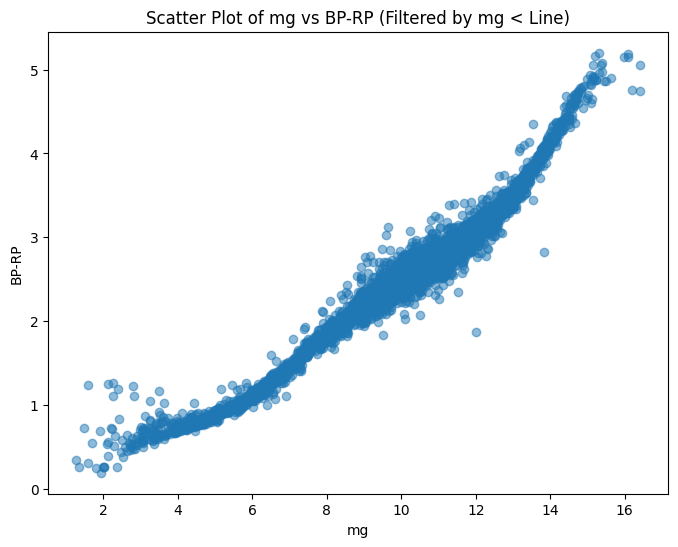

In [60]:
# plotting the filtered data
plt.figure(figsize=(8, 6))
plt.scatter(afterExclude_df['mg'], afterExclude_df['bp_rp'], alpha=0.5)

plt.xlabel('mg')
plt.ylabel('BP-RP')
plt.title('Scatter Plot of mg vs BP-RP (Filtered by mg < Line)')
plt.show()

In [61]:
def linear_model(BP_RP=None, MG=None):
    # priors
    m = numpyro.sample('m', dist.Normal(scale=10)) #scale=10 sets σ of the norm.dist to 10 by default μ is 0
    b = numpyro.sample('b', dist.Normal(loc=300, scale=100)) #mu is 300 and sigma is 100
    σ = numpyro.sample('sigma', dist.HalfNormal(scale=20)) 

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ", m * BP_RP + b)

    # Likelihood (sampling distribution) of observations
    if MG is not None:
        with numpyro.plate("afterExclude_df", len(MG)):
            obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)


In [62]:
# Preparing data
BP_RP = afterExclude_df['bp_rp'].values
MG = afterExclude_df['mg'].values

# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(linear_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP, 
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      2.58      0.03      2.59      2.54      2.63   3673.72      1.00
         m      2.94      0.01      2.94      2.92      2.95   3718.25      1.00
     sigma      0.57      0.01      0.57      0.56      0.58   4934.62      1.00

Number of divergences: 0


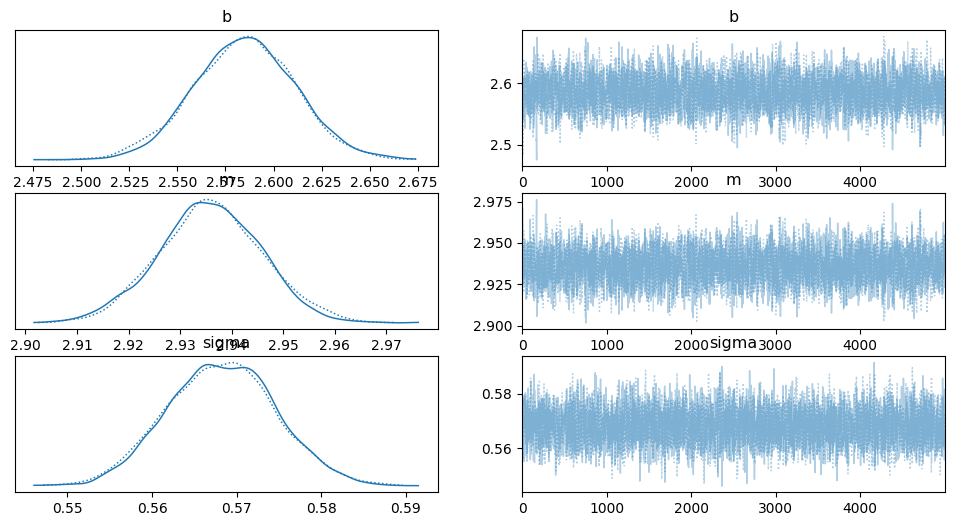

In [63]:
az.plot_trace(mcmc, var_names=["~μ"]);

A. Discuss the differences between the prior distributions you choose for your model parameters and the marginal (i.e., one-dimensional) posterior distributions estimated with your MCMC. Did you choose suitably uninformed priors?

I chose a wide prior for m (-10 to 10), which was too broad compared to the narrow posterior range (2.90 to 2.97). The data suggests a much smaller range, indicating the prior was too uninformed. The prior for b was from -100 to 100 with a mean of 300, which was unrealistic and too wide for this problem.The posterior mean (0.55 to 0.59) is much more reasonable, showing that the data provided strong information that overruled the prior. I set σ to 20, which was too large and overly vague.The data suggests a smaller value, indicating the prior was not suitable.The priors were overly broad and not realistic for the data. I should have used more informative priors based on reasonable expectations.

B. Plot the models corresponding to 50 randomly chosen posterior samples from your MCMC. Discuss the quality of the fit, and in particular the role that the standard deviation parameter is playing in this fit.

In [64]:
samples = mcmc.get_samples()

tgrid = np.linspace(BP_RP.min(), BP_RP.max(), 20)
post_pred_samples = infer.Predictive(linear_model, samples)(random.PRNGKey(1), BP_RP=tgrid)

post_pred_mu = post_pred_samples['μ']  

post_pred_mu.shape

(10000, 20)

In [65]:
print(post_pred_samples.keys())

dict_keys(['μ'])


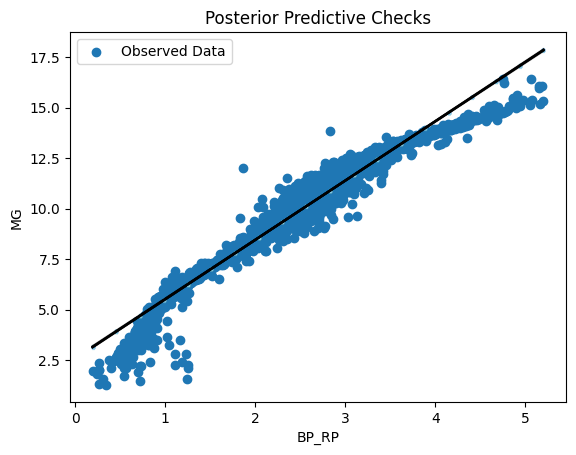

In [66]:

plt.scatter(BP_RP, MG, label='Observed Data')
for i in random.choice(rng_key, len(post_pred_mu), (50,)): 
    plt.plot(tgrid, post_pred_mu[i], color='black', alpha=0.1)
    plt.scatter(tgrid, post_pred_mu[i], color='skyblue', marker=',', s=1, alpha=0.1)

plt.xlabel("BP_RP")
plt.ylabel("MG")
plt.title("Posterior Predictive Checks")
plt.legend()
plt.show()

Q2.

In [67]:
def quad_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**2 + b*BP_RP + c) 

    # Likelihood (sampling distribution) of observations
    if MG is not None:
        with numpyro.plate("afterExclude_df", len(MG)):
            obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [68]:
# Preparing data
BP_RP = afterExclude_df['bp_rp'].values
MG = afterExclude_df['mg'].values

# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(quad_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.30      0.01     -0.30     -0.31     -0.29   2719.42      1.00
         b      4.40      0.03      4.40      4.35      4.46   2565.25      1.00
         c      1.06      0.04      1.06      1.00      1.12   2577.80      1.00
   scatter      0.45      0.01      0.45      0.44      0.46   4051.34      1.00

Number of divergences: 0


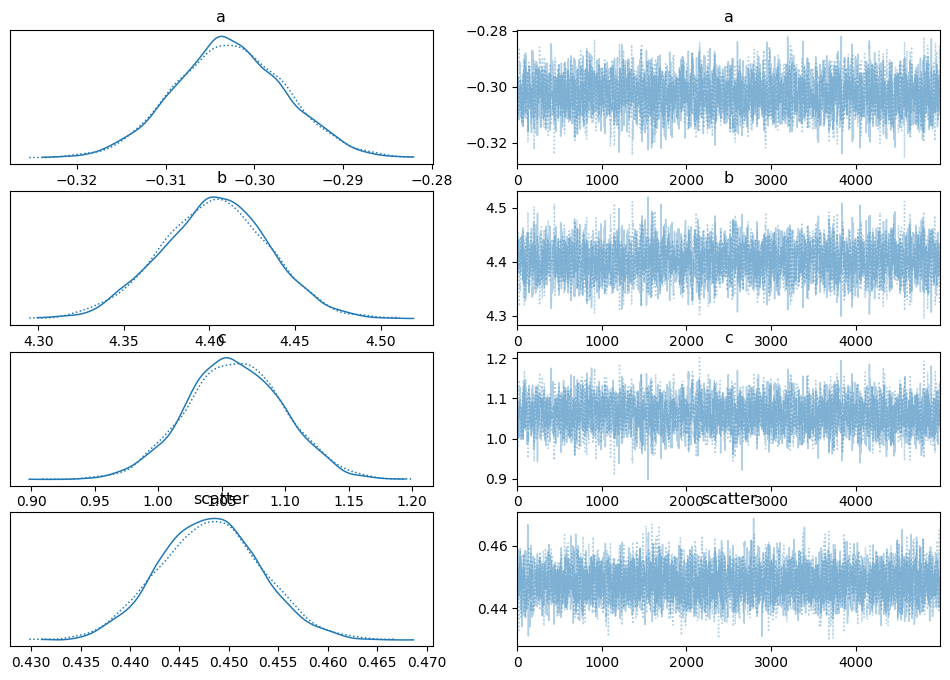

In [69]:
az.plot_trace(mcmc, var_names=["~μ"]);

Q2.A. Discuss the differences between the prior distributions you choose for your model parameters and the marginal (i.e., one-dimensional) posterior distributions estimated with your MCMC. Did you choose suitably uninformed priors?

Q2.B. Plot the model corresponding to 50 randomly chosen posterior samples from your MCMC. Discuss the quality of the fit.

In [70]:
samples1 = mcmc.get_samples()

tgrid = np.linspace(BP_RP.min(), BP_RP.max(), 20)
post_pred_samples1 = infer.Predictive(quad_model, samples1)(random.PRNGKey(1), BP_RP=tgrid, MG = None)

post_pred_mu1 = post_pred_samples1['μ']  


post_pred_mu1.shape

(10000, 20)

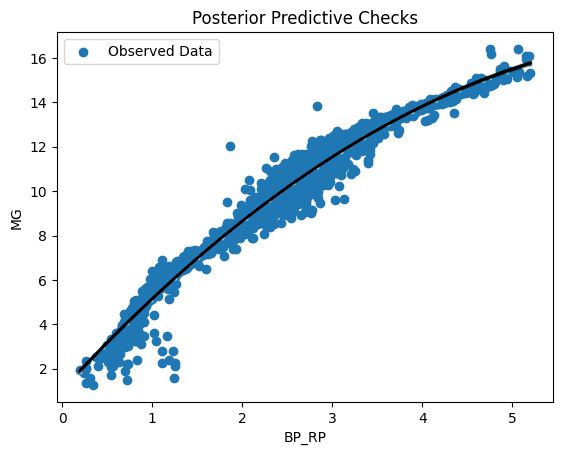

In [71]:
plt.scatter(BP_RP, MG, label='Observed Data')
for i in random.choice(rng_key, len(post_pred_mu1), (50,)): 
    plt.plot(tgrid, post_pred_mu1[i], color='black', alpha=0.1)
    plt.scatter(tgrid, post_pred_mu1[i], color='skyblue', marker=',', s=1, alpha=0.1)

plt.xlabel("BP_RP")
plt.ylabel("MG")
plt.title("Posterior Predictive Checks")
plt.legend()
plt.show()

Q2.C. Graduate students: Use your posterior estimates to predict the distribution we would expect for MG values of main sequence stars with color (BP−RP)=6.

In [72]:
def quad_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**2 + b*BP_RP+ c) 

    # Likelihood (sampling distribution) of observations
    with numpyro.plate("afterExclude_df", len(MG)):
        obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [73]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(quad_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.30      0.01     -0.30     -0.31     -0.29   2719.42      1.00
         b      4.40      0.03      4.40      4.35      4.46   2565.25      1.00
         c      1.06      0.04      1.06      1.00      1.12   2577.80      1.00
   scatter      0.45      0.01      0.45      0.44      0.46   4051.34      1.00

Number of divergences: 0


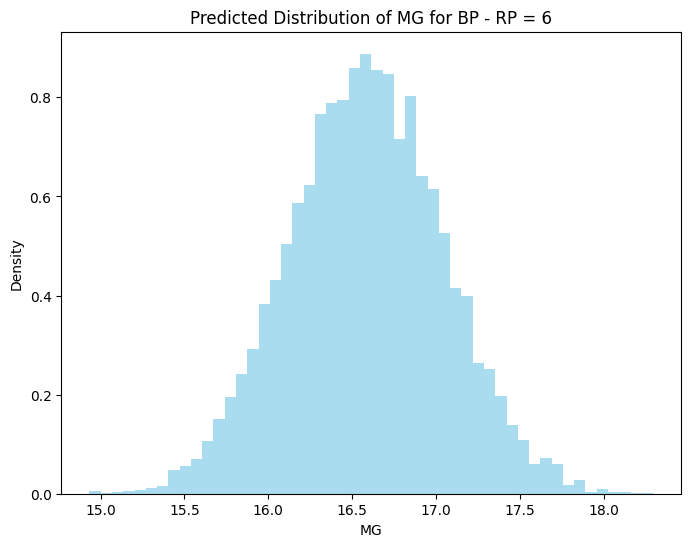

In [74]:
posterior_samples = mcmc.get_samples()
# generate prediction funtion
def pred_model(posterior_samples, BP_RP_test):
    # Extract posterior samples for parameters
    a_samples = posterior_samples['a']
    b_samples = posterior_samples['b']
    c_samples = posterior_samples['c']
    σ_samples = posterior_samples['scatter']
    
    # making an array of BP_RP_test to make compatible with other parameters
    BP_RP_test = jnp.broadcast_to(BP_RP_test, a_samples.shape)
    
    μ_samples = a_samples * BP_RP_test**2 + b_samples * BP_RP_test + c_samples
    
    # Broadcast the σ_samples to the same shape as μ_samples if needed
    if σ_samples.shape != μ_samples.shape:
        σ_samples = jnp.broadcast_to(σ_samples, μ_samples.shape)
    
    # Now generate the predicted MG values using the posterior samples
    MG_samples = μ_samples + σ_samples * jax.random.normal(jax.random.PRNGKey(0), μ_samples.shape)
    
    return MG_samples

BP_RP_test = jnp.array([6.0])  # color value of BP - RP

predicted_MG = pred_model(posterior_samples, BP_RP_test)

plt.figure(figsize=(8, 6))
plt.hist(predicted_MG, bins=50, density=True, alpha=0.7, color='skyblue')
plt.title('Predicted Distribution of MG for BP - RP = 6')
plt.xlabel('MG')
plt.ylabel('Density')
plt.show()

Q3.Graduate students: Explore higher order polynomials a bit. How does the (qualitative) quality of the fit behave?

In [75]:
def HOP_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=100))
    d = numpyro.sample('d', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**3 + b*BP_RP**2+ c*BP_RP + d) 

    # Likelihood (sampling distribution) of observations
    if MG is not None:  
        with numpyro.plate("afterExclude_df", len(MG)):
            obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [76]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(HOP_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.02      0.01     -0.02     -0.03     -0.01   1940.59      1.00
         b     -0.17      0.04     -0.18     -0.25     -0.10   1865.08      1.00
         c      4.11      0.10      4.11      3.95      4.28   1831.00      1.00
         d      1.24      0.07      1.24      1.13      1.36   1927.15      1.00
   scatter      0.45      0.01      0.45      0.44      0.46   3301.23      1.00

Number of divergences: 0


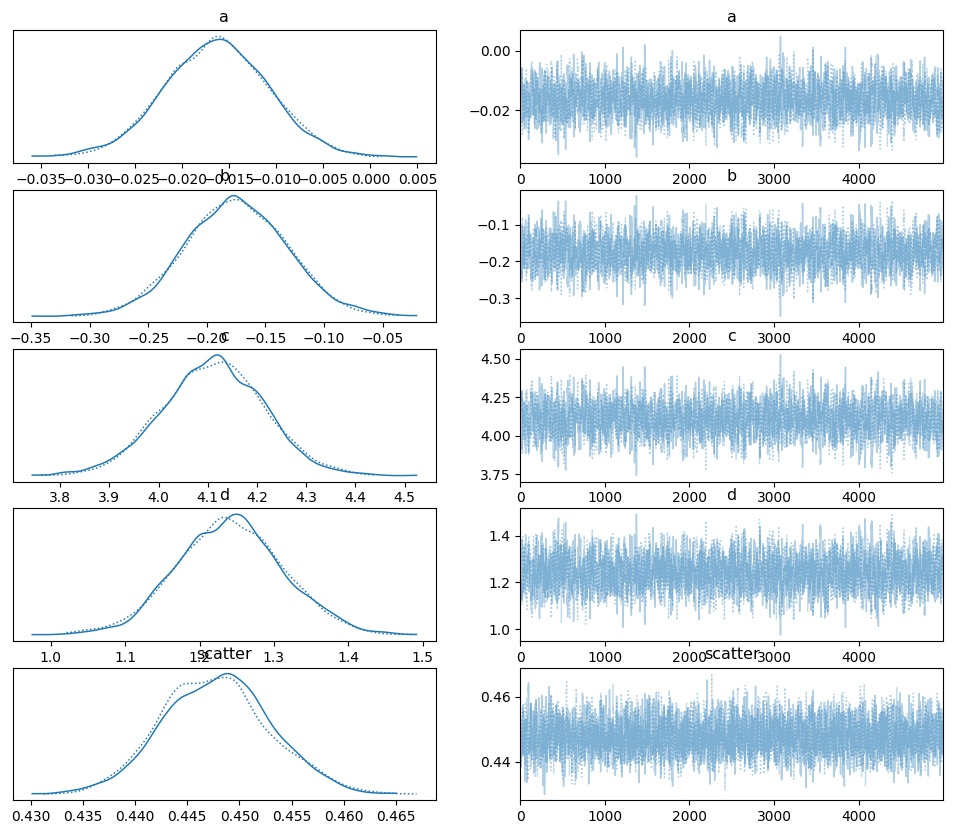

In [77]:
az.plot_trace(mcmc, var_names=["~μ"]);

In [78]:
samples2 = mcmc.get_samples()

tgrid = np.linspace(BP_RP.min(), BP_RP.max(), 20)
post_pred_samples2 = infer.Predictive(HOP_model, samples2)(random.PRNGKey(1), BP_RP=tgrid, MG = None)

post_pred_mu2 = post_pred_samples2['μ']  


post_pred_mu2.shape

(10000, 20)

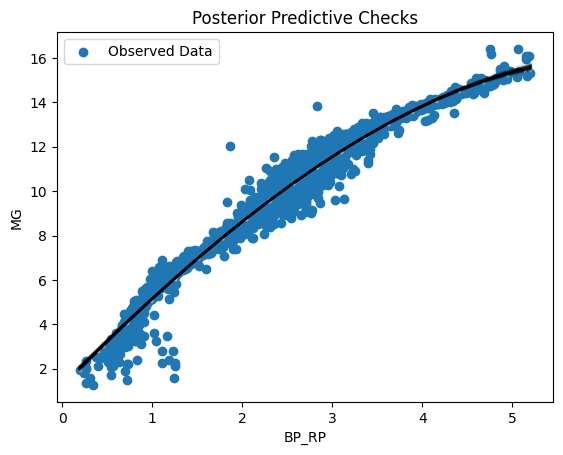

In [79]:
plt.scatter(BP_RP, MG, label='Observed Data')
for i in random.choice(rng_key, len(post_pred_mu2), (50,)): 
    plt.plot(tgrid, post_pred_mu2[i], color='black', alpha=0.1)
    plt.scatter(tgrid, post_pred_mu2[i], color='skyblue', marker=',', s=1, alpha=0.1)

plt.xlabel("BP_RP")
plt.ylabel("MG")
plt.title("Posterior Predictive Checks")
plt.legend()
plt.show()

In [80]:
def HOP1_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=100))
    d = numpyro.sample('d', dist.Normal(scale=100))
    e = numpyro.sample('e', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**4 + b*BP_RP**3+ c*BP_RP**2 + d*BP_RP + e)

    # Likelihood (sampling distribution) of observations
    if MG is not None:
        with numpyro.plate("afterExclude_df", len(MG)):
            obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [81]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(HOP_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.02      0.01     -0.02     -0.03     -0.01   1940.59      1.00
         b     -0.17      0.04     -0.18     -0.25     -0.10   1865.08      1.00
         c      4.11      0.10      4.11      3.95      4.28   1831.00      1.00
         d      1.24      0.07      1.24      1.13      1.36   1927.15      1.00
   scatter      0.45      0.01      0.45      0.44      0.46   3301.23      1.00

Number of divergences: 0


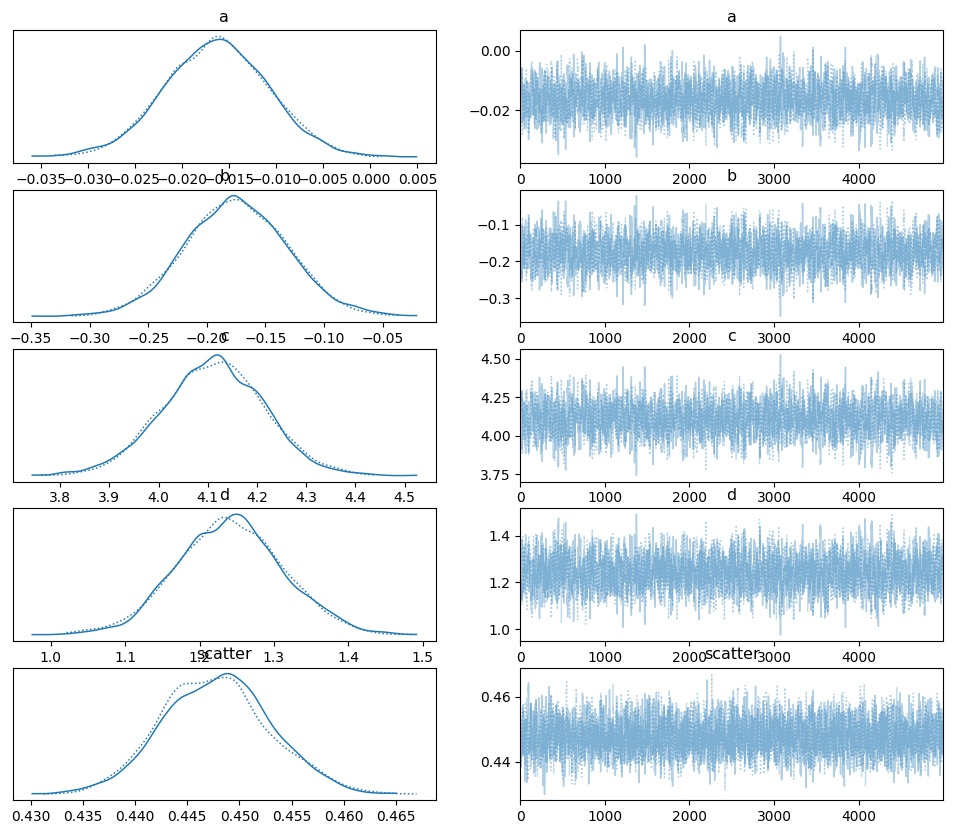

In [82]:
az.plot_trace(mcmc, var_names=["~μ"]);

In [83]:
samples3 = mcmc.get_samples()

tgrid = np.linspace(BP_RP.min(), BP_RP.max(), 20)
post_pred_samples3 = infer.Predictive(HOP1_model, samples3)(random.PRNGKey(1), BP_RP=tgrid, MG = None)

post_pred_mu3 = post_pred_samples3['μ']  


post_pred_mu3.shape

(10000, 20)

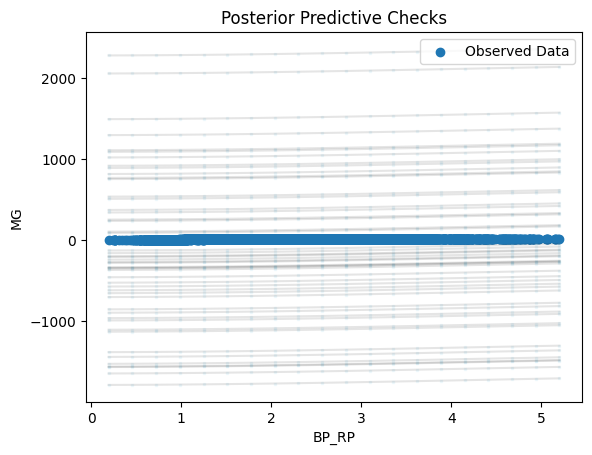

In [84]:
plt.scatter(BP_RP, MG, label='Observed Data')
for i in random.choice(rng_key, len(post_pred_mu3), (50,)): 
    plt.plot(tgrid, post_pred_mu3[i], color='black', alpha=0.1)
    plt.scatter(tgrid, post_pred_mu3[i], color='skyblue', marker=',', s=1, alpha=0.1)

plt.xlabel("BP_RP")
plt.ylabel("MG")
plt.title("Posterior Predictive Checks")
plt.legend()
plt.show()

In [85]:
def HOP2_model(BP_RP=None, MG=None):
    # priors
    a = numpyro.sample('a', dist.Normal(scale=100))
    b = numpyro.sample('b', dist.Normal(scale=100))
    c = numpyro.sample('c', dist.Normal(scale=100))
    d = numpyro.sample('d', dist.Normal(scale=100))
    e = numpyro.sample('e', dist.Normal(scale=1000))
    f = numpyro.sample('f', dist.Normal(scale=1000))

    σ = numpyro.sample('scatter', dist.HalfNormal(scale=20))

    # Define the mean of the normal likelihood
    μ = numpyro.deterministic("μ",  a*BP_RP**5 + b*BP_RP**4+ c*BP_RP**3 + d*BP_RP**2 + e*BP_RP + f)

    # Likelihood (sampling distribution) of observations
    if MG is not None:
        with numpyro.plate("afterExclude_df", len(MG)):
            obs = numpyro.sample('BP_RP', dist.Normal(loc=μ, scale=σ), obs=MG)

In [86]:
# Generate a starting key, which we'll split for later operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

kernel = infer.NUTS(HOP_model)
num_samples = 5000
mcmc = infer.MCMC(
    kernel,
    num_chains=2,
    num_warmup=1000,
    num_samples=num_samples)
mcmc.run(rng_key_,
         BP_RP,
         MG)
mcmc.print_summary()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.02      0.01     -0.02     -0.03     -0.01   1940.59      1.00
         b     -0.17      0.04     -0.18     -0.25     -0.10   1865.08      1.00
         c      4.11      0.10      4.11      3.95      4.28   1831.00      1.00
         d      1.24      0.07      1.24      1.13      1.36   1927.15      1.00
   scatter      0.45      0.01      0.45      0.44      0.46   3301.23      1.00

Number of divergences: 0


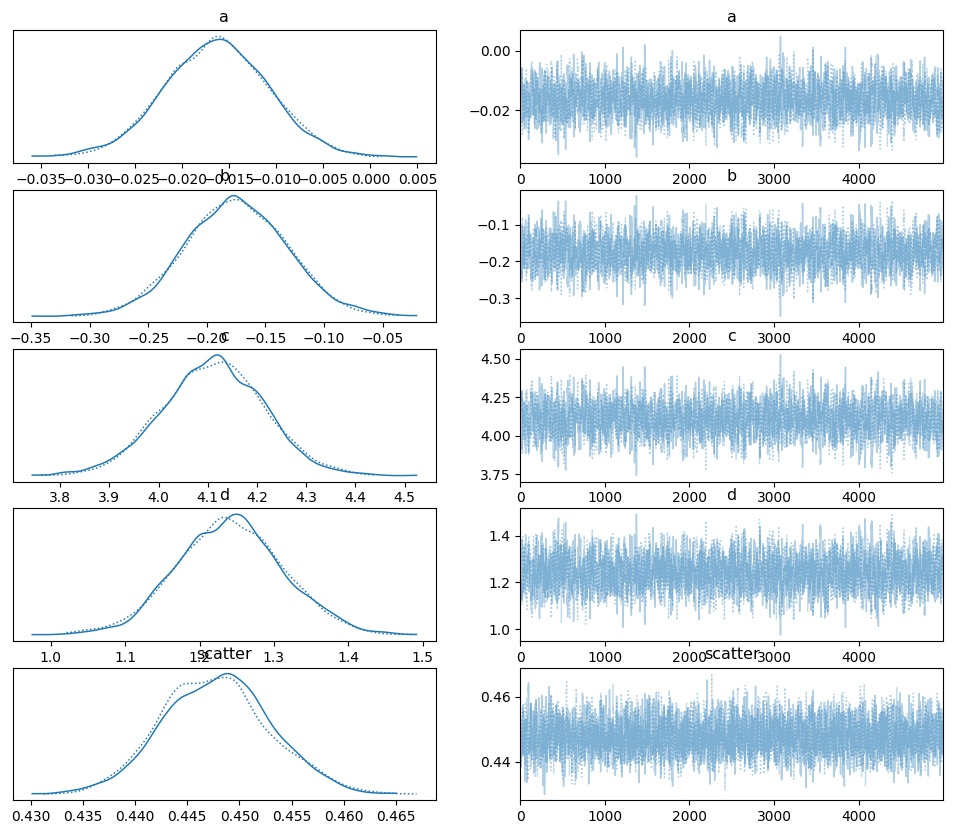

In [87]:
az.plot_trace(mcmc, var_names=["~μ"]);

In [88]:
samples4 = mcmc.get_samples()

tgrid = np.linspace(BP_RP.min(), BP_RP.max(), 20)
post_pred_samples4 = infer.Predictive(HOP2_model, samples4)(random.PRNGKey(1), BP_RP=tgrid, MG = None)

post_pred_mu4 = post_pred_samples4['μ']  


post_pred_mu4.shape

(10000, 20)

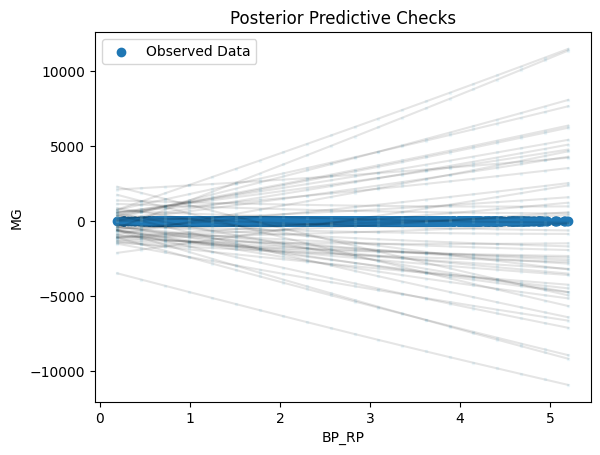

In [91]:
plt.scatter(BP_RP, MG, label='Observed Data')
for i in random.choice(rng_key, len(post_pred_mu4), (50,)): 
    plt.plot(tgrid, post_pred_mu4[i], color='black', alpha=0.1)
    plt.scatter(tgrid, post_pred_mu4[i], color='skyblue', marker=',',s=1, alpha=0.1)

plt.xlabel("BP_RP")
plt.ylabel("MG")
plt.title("Posterior Predictive Checks")
plt.legend()
plt.show()